# 2.03a - Clustering on IOB and COB only



In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering
from src.sample_filter import SampleFilter
from src.time_series_analysis import plot_night_time_series
from src.config import FIGURES_DIR, PROCESSED_DATA_DIR
from src.helper import cluster_colours

2025-08-11 17:45:34.596 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


KeyboardInterrupt: 

In [17]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample.get_consolidated_df()
sample.return_counts()
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))

df_variables = df[['bg mean', 'bg min', 'bg max', 'bg std', 'iob mean', 'iob max', 'cob mean', 'cob max', 'bg count',  'iob count', 'cob count']].copy().astype(float)

cluster_range = range(2,8)
night_start_hour = 17
feature_variables=['iob mean', 'iob max', 'cob mean', 'cob max']

2025-08-03 20:47:57.312 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
2025-08-03 20:48:04.167 | INFO     | src.sample_filter:__init__:68 - Number of nights objects created: 83
2025-08-03 20:48:10.038 | INFO     | src.sample_filter:return_counts:139 - For sample rate of 30 minutes:
  min_nights=30
  missed_intervals=1
2025-08-03 20:48:10.038 | INFO     | src.sample_filter:return_counts:142 - Number of candidates: 16
2025-08-03 20:48:10.038 | INFO     | src.sample_filter:return_counts:143 - Number of nights: 922


## Experiment 1: 'Efficient' Automated Feature Creation -tsfresh

Feature Extraction: 100%|██████████| 3688/3688 [03:24<00:00, 18.01it/s]


Extracted 3108 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped 1519 features.
PCA reduced dimensions from 1589 to 235.

Preprocessed PCA features for nights:
[[ 4.81888596e+00 -3.66306319e+00 -1.30218985e+01 ...  6.54497997e-01
  -4.84748452e-01  1.81078289e-01]
 [ 1.54470338e+01  1.40448596e+01 -1.75613681e+01 ... -7.66202673e-01
   1.08164284e+00  2.09598165e-01]
 [ 2.74553274e+01 -7.65807469e+00 -1.74047557e+01 ... -9.94934416e-01
  -2.21434717e+00  5.52878035e-01]
 [ 2.67967603e+01  6.09322578e+00  1.16101043e+01 ... -2.59757911e-01
  -9.01187279e-01  1.50149053e+00]
 [ 1.02174719e+01  3.33756172e+00  1.34367255e+01 ...  5.52206751e-01
  -3.09369392e-01 -1.20703387e-02]]


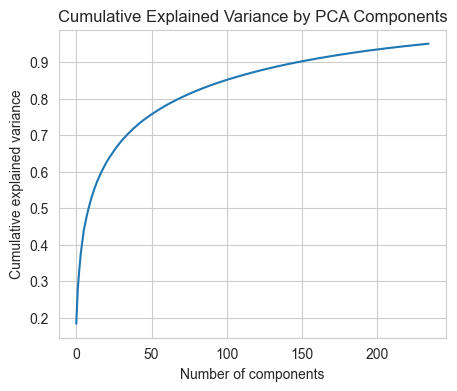

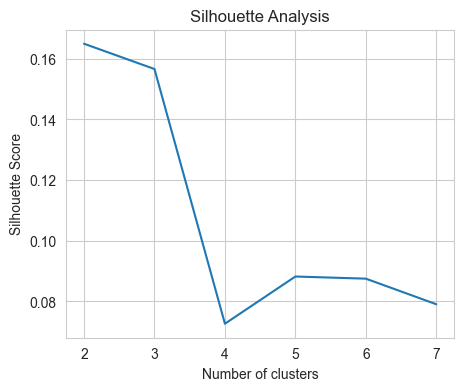

In [18]:
warnings.filterwarnings('ignore')

eff_analyser = NightClustering(df=df_variables, feature_settings='efficient', night_start_hour=night_start_hour, feature_variables=feature_variables)
night_features = eff_analyser.extract_night_level_features(multi_threaded=True)

# Preprocess Night-Level Features (Scale and PCA)
pca_features = eff_analyser.preprocess_night_features(n_components=0.95)
print("\nPreprocessed PCA features for nights:")
print(pca_features[:5])

# Plot the cumulative explained variance to help decide on the number of components
eff_analyser.plot_pca_cumulative_variance()
baseline_silhoutte_scores = eff_analyser.silhouette_analysis(cluster_range)
warnings.filterwarnings('default')

## Experiment 2: Custom Feature Creation - tsfresh

Feature Extraction: 100%|██████████| 3688/3688 [00:02<00:00, 1455.48it/s]


Extracted 48 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'cob mean__minimum', 'iob max__count_above__t_100', 'cob max__minimum'}
PCA reduced dimensions from 45 to 14.


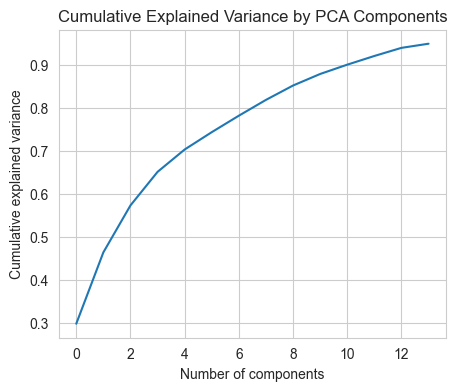

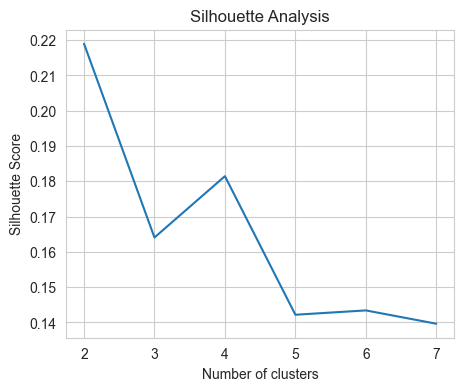

In [19]:
warnings.filterwarnings('ignore')
cust_analyser = NightClustering(df=df_variables, feature_settings='custom_no_bg', night_start_hour=night_start_hour, feature_variables=feature_variables)
night_features = cust_analyser.extract_night_level_features(multi_threaded=False)
pca_features = cust_analyser.preprocess_night_features(n_components=0.95)
cust_analyser.plot_pca_cumulative_variance()
custom_silhouette_scores = cust_analyser.silhouette_analysis(cluster_range)
warnings.filterwarnings('default')

### PCA with 14 Components and 4 Clusters

Explained variance: [0.29860965 0.16602472 0.1092206  0.07805858 0.05199139 0.0403661
 0.03832148 0.03676425 0.03342107 0.02684967 0.02166023 0.02019986
 0.01890546 0.00962938]
Night cluster distribution:
(array([0, 1, 2, 3], dtype=int32), array([124, 106, 264, 428]))


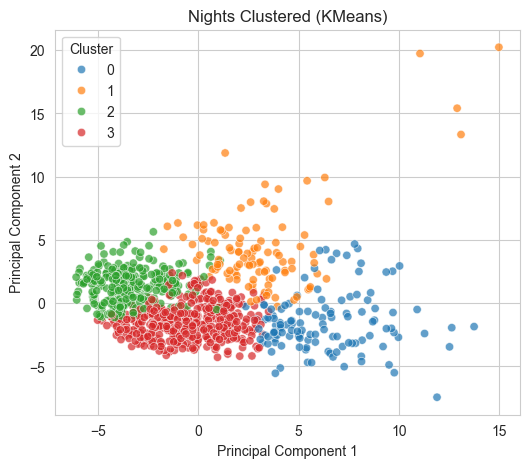

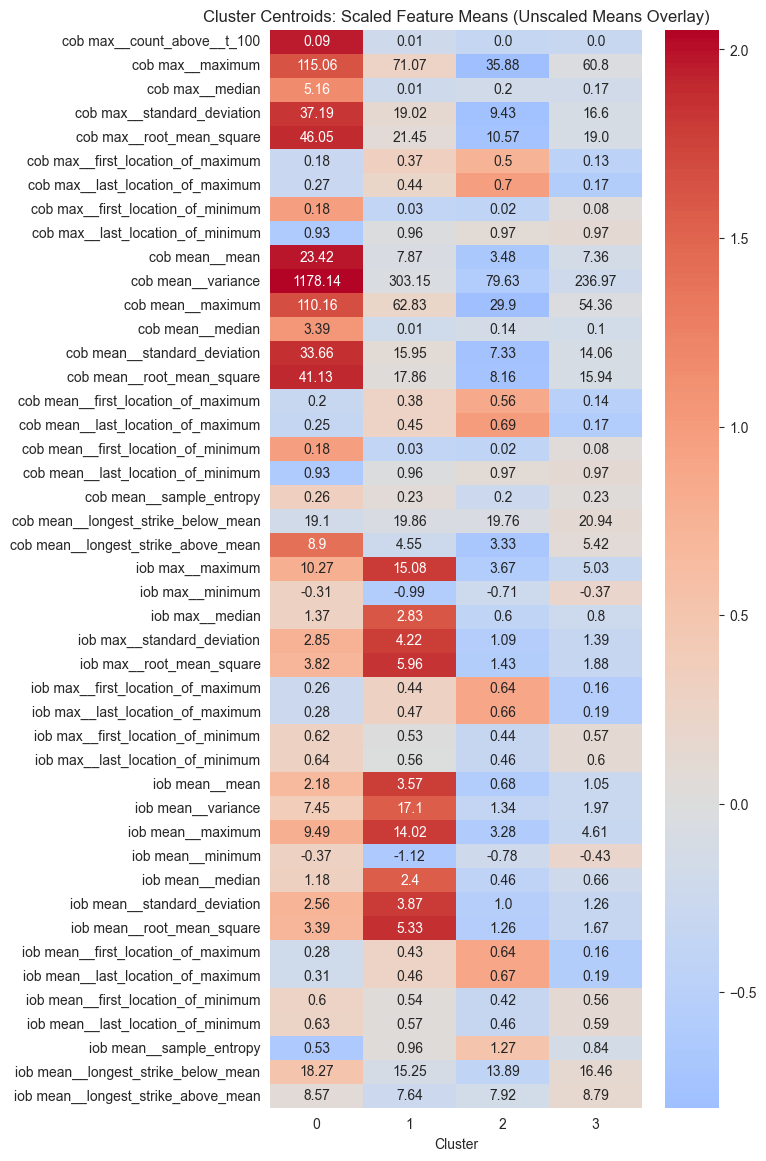

In [20]:
print(f'Explained variance: {cust_analyser.pca_model.explained_variance_ratio_}')
night_clusters = cust_analyser.cluster_nights(n_clusters=4)
cust_analyser.heatmap_cluster_features()

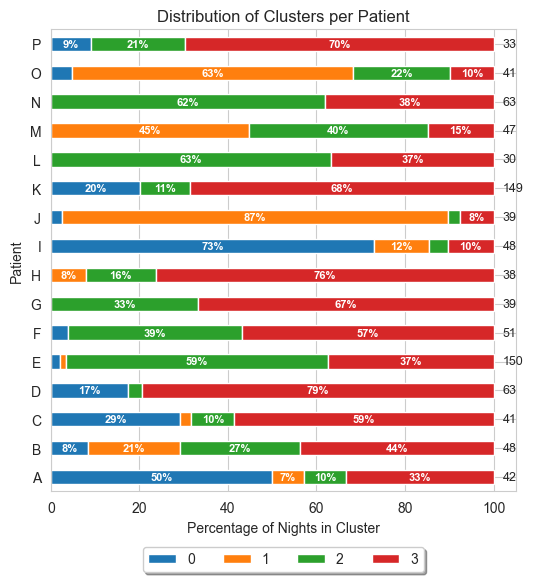

Mean entropy of cluster distribution per patient: 1.021
Normalised mean entropy of cluster distribution per patient: 0.510
Mean Gini coefficient of cluster distribution per patient: 0.514


In [21]:
cust_analyser.plot_cluster_distribution()
entropy = cust_analyser.calculate_distribution_metrics()

Plotting t-SNE with original clusters


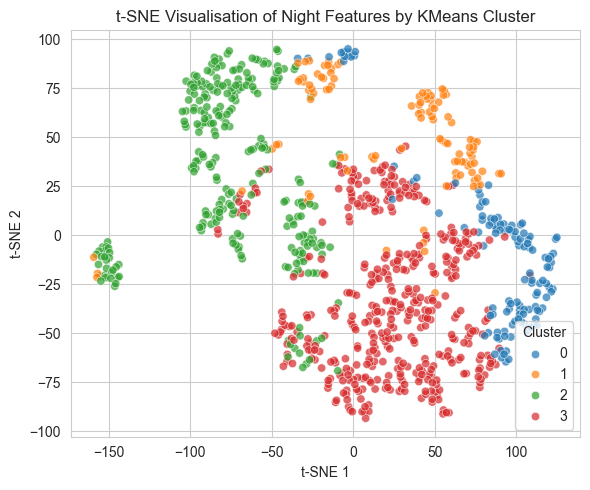

In [22]:
print('Plotting t-SNE with original clusters')
kwargs = {'perplexity': 10, 'max_iter': 80000}
cust_analyser.fit_tsne(**kwargs)
cust_analyser.plot_tsne(cluster_type='kmeans')

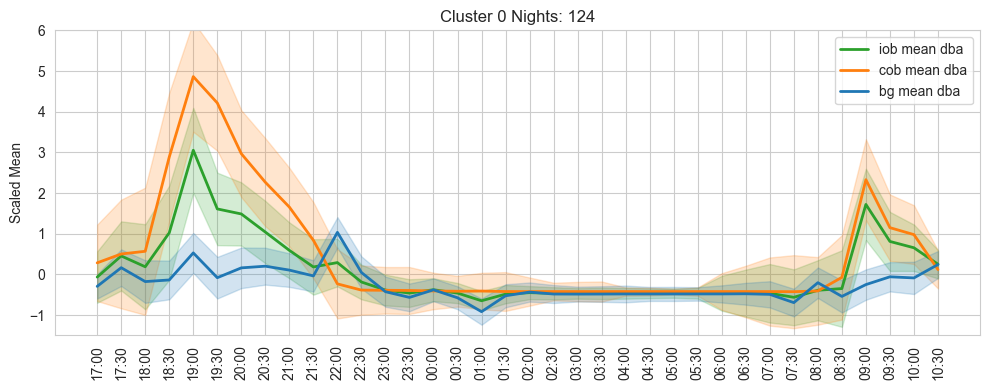

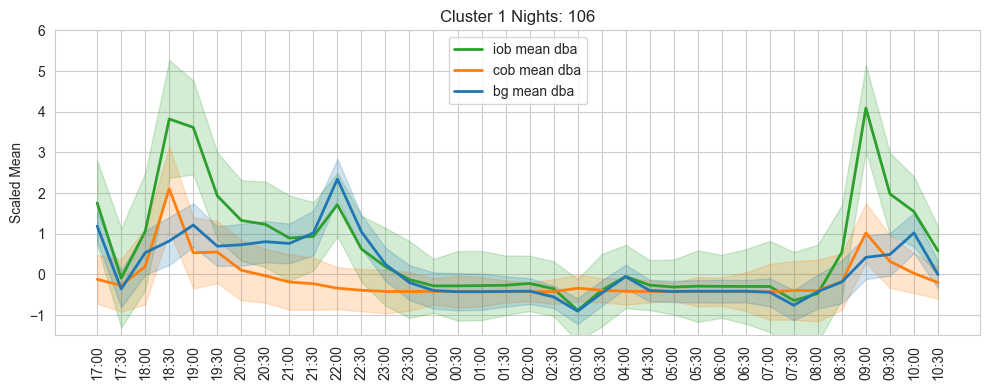

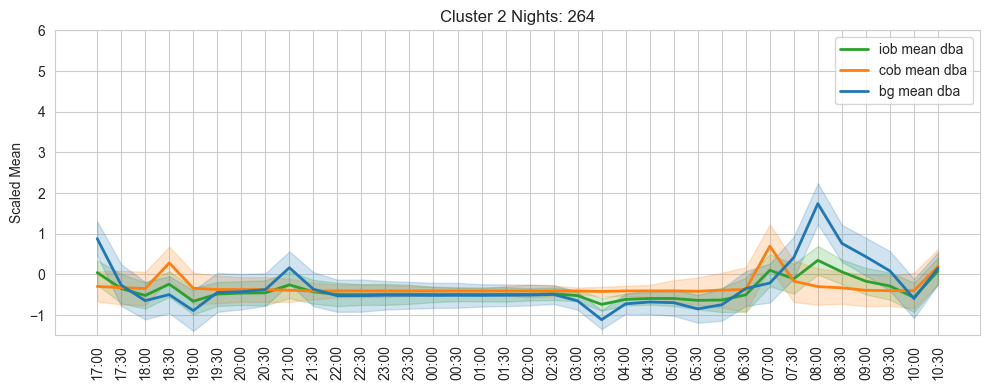

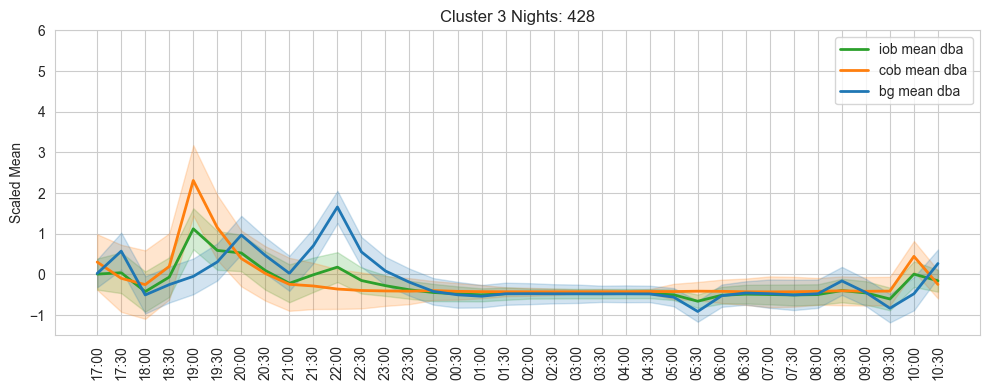

In [23]:
scaled_all_df = cust_analyser.return_dataset_with_clusters(scaled=True)
for cluster, df_cluster in scaled_all_df.groupby('cluster_label'):
    plot_night_time_series(df_cluster, night_start=night_start.hour, morning_end=morning_end.hour, method='dba', rolling_window=3, y_limits=(-1.5, 6), prescaled=True, cluster=cluster)

In [24]:
cust_analyser.return_dataset_with_clusters()

night_start_date  index  bg mean  bg min  bg max  \
id       datetime                                                               
15558575 2018-04-17 17:00:00       2018-04-17      0  145.500   127.0   159.0   
         2018-04-17 17:30:00       2018-04-17      1   97.500    93.0   102.0   
         2018-04-17 18:00:00       2018-04-17      2   71.500    66.0    77.0   
         2018-04-17 18:30:00       2018-04-17      3   76.000    76.0    76.0   
         2018-04-17 19:00:00       2018-04-17      4  110.000   110.0   110.0   
...                                       ...    ...      ...     ...     ...   
97417885 2018-02-18 08:30:00       2018-02-17  32739  116.333   114.0   118.0   
         2018-02-18 09:00:00       2018-02-17  32740  117.500   116.0   119.0   
         2018-02-18 09:30:00       2018-02-17  32741  120.000   119.0   121.0   
         2018-02-18 10:00:00       2018-02-17  32742  121.889   116.0   127.0   
         2018-02-18 10:30:00       2018-02-17  32743  127.500   123.0   132.0   

                              bg std  iob mean  iob max  cob mean  cob max  \
id       datetime                                                            
15558575 2018-04-17 17:00:00  14.248     2.609    7.776     16.25     65.0   
         2018-04-17 17:30:00   6.364     6.045    6.425     58.50     59.0   
         2018-04-17 18:00:00   7.778     4.101    4.825     49.00     52.0   
         2018-04-17 18:30:00     NaN     1.623    1.623     51.00     51.0   
         2018-04-17 19:00:00     NaN     1.869    1.869     37.00     37.0   
...                              ...       ...      ...       ...      ...   
97417885 2018-02-18 08:30:00   2.082     0.193    0.272      0.00      0.0   
         2018-02-18 09:00:00   1.291     0.130    0.180      0.00      0.0   
         2018-02-18 09:30:00   1.414     0.152    0.160      0.00      0.0   
         2018-02-18 10:00:00   3.723     0.268    0.443      0.00      0.0   
         2018-02-18 10:30:00   3.391     0.313    0.410      0.00      0.0   

                              bg count  iob count  cob count  cluster_label  
id       datetime                                                            
15558575 2018-04-17 17:00:00       4.0        4.0        4.0              3  
         2018-04-17 17:30:00       2.0        2.0        2.0              3  
         2018-04-17 18:00:00       2.0        2.0        2.0              3  
         2018-04-17 18:30:00       1.0        1.0        1.0              3  
         2018-04-17 19:00:00       1.0        1.0        1.0              3  
...                                ...        ...        ...            ...  
97417885 2018-02-18 08:30:00       3.0        3.0        3.0              3  
         2018-02-18 09:00:00       4.0        4.0        4.0              3  
         2018-02-18 09:30:00       2.0        2.0        2.0              3  
         2018-02-18 10:00:00       9.0        9.0        9.0              3  
         2018-02-18 10:30:00       6.0        6.0        6.0              3  

[32744 rows x 14 columns]

In [25]:
# Pickle object for later use
with open(PROCESSED_DATA_DIR / 'cust_analyser.pkl', 'wb') as file:
    pickle.dump(cust_analyser, file)

### PCA with 2 Components and 3 clusters

Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'cob mean__minimum', 'iob max__count_above__t_100', 'cob max__minimum'}
PCA reduced dimensions from 45 to 2.
Explained variance: [0.29860965 0.16602472]


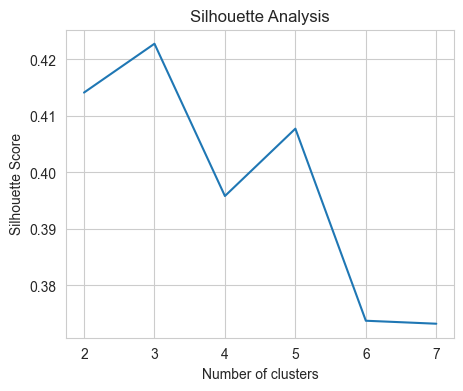

Night cluster distribution:
(array([0, 1, 2], dtype=int32), array([107, 529, 286]))


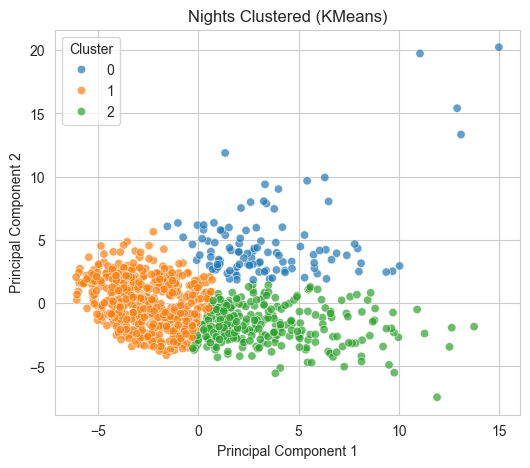

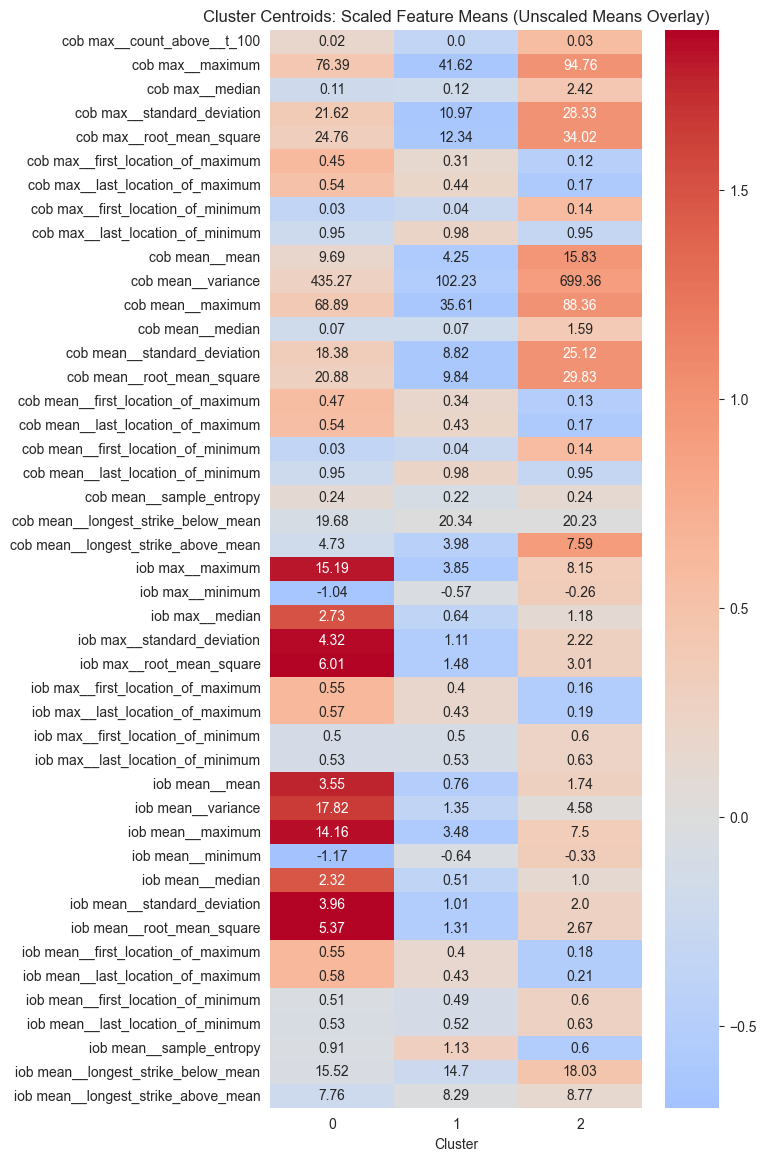

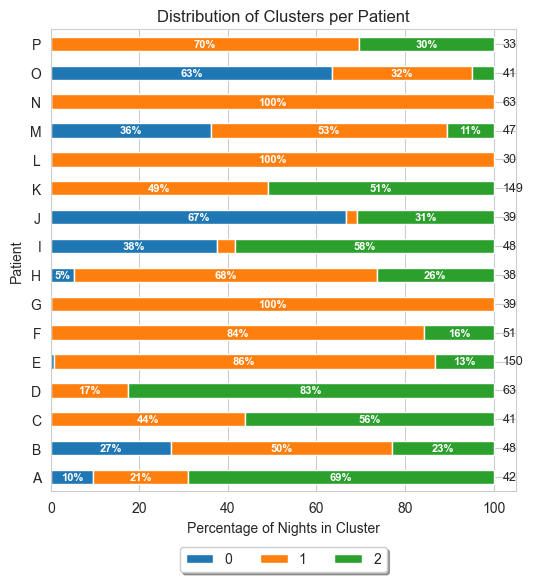

Mean entropy of cluster distribution per patient: 0.808
Normalised mean entropy of cluster distribution per patient: 0.510
Mean Gini coefficient of cluster distribution per patient: 0.458
Plotting t-SNE with original clusters


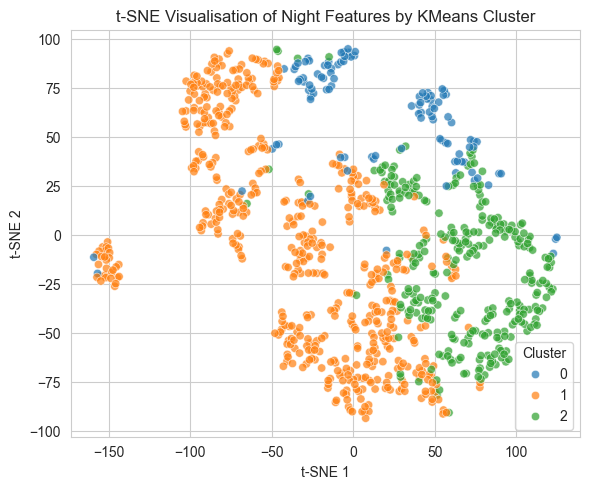

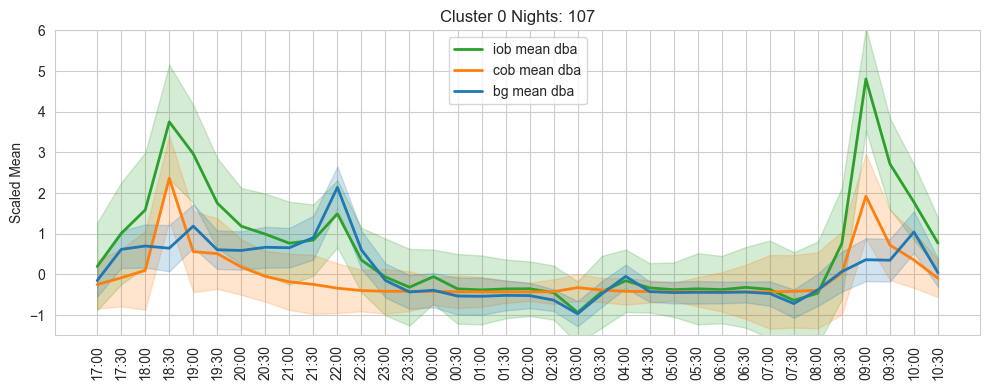

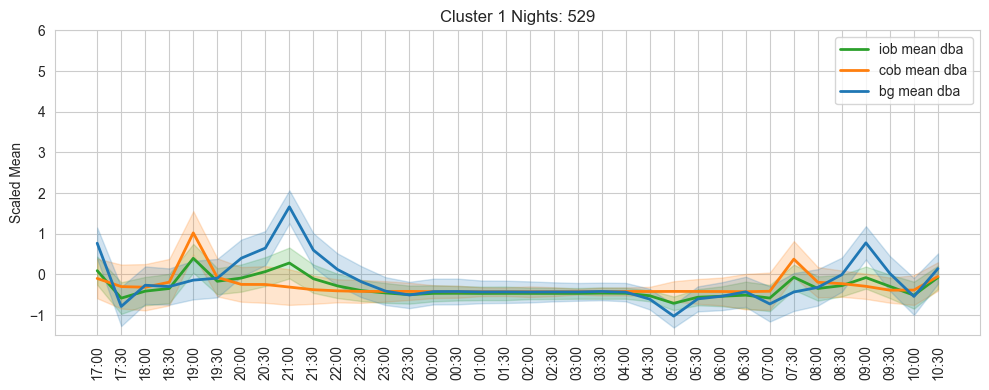

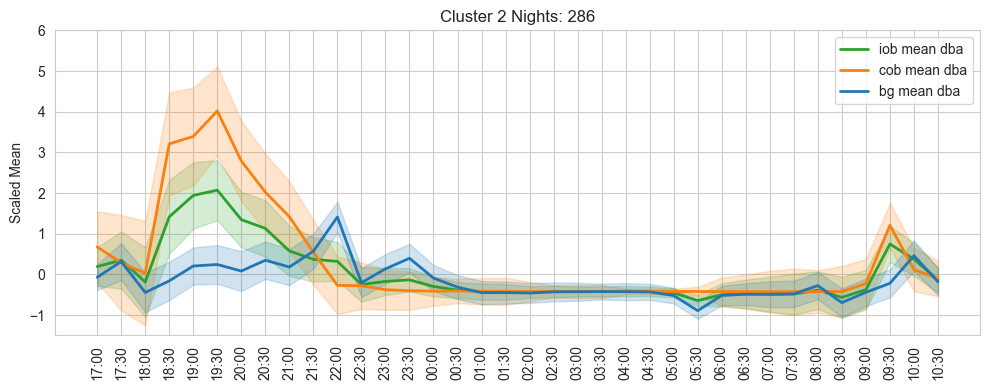

In [26]:
# Using 2 PCA components
pca2_analyser = cust_analyser
pca_features = pca2_analyser.preprocess_night_features(n_components=2)
print(
    f'Explained variance: {pca2_analyser.pca_model.explained_variance_ratio_}')
pca2_silhouette_scores = pca2_analyser.silhouette_analysis(cluster_range)
night_clusters = pca2_analyser.cluster_nights(n_clusters=3)
pca2_analyser.heatmap_cluster_features()
pca2_analyser.plot_cluster_distribution()
entropy = pca2_analyser.calculate_distribution_metrics()
print('Plotting t-SNE with original clusters')
kwargs = {'perplexity': 10, 'max_iter': 80000}
pca2_analyser.fit_tsne(**kwargs)
pca2_analyser.plot_tsne(cluster_type='kmeans')
scaled_pca2_df = pca2_analyser.return_dataset_with_clusters(scaled=True)
for cluster, df_cluster in scaled_pca2_df.groupby('cluster_label'):
    plot_night_time_series(df_cluster, night_start=night_start.hour, morning_end=morning_end.hour, method='dba', rolling_window=3, y_limits=(-1.5, 6), prescaled=True, cluster=cluster)

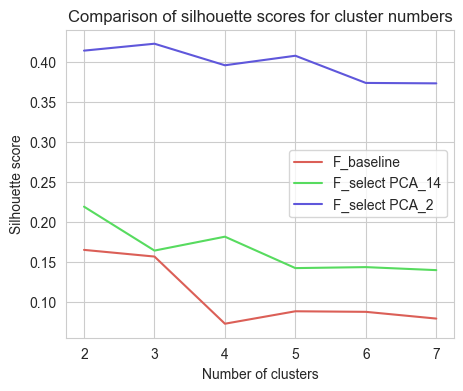

In [27]:
# Comparison of silhouette scores for the models
data = {'n_clusters': cluster_range,
        'F_baseline': baseline_silhoutte_scores,
        'F_select PCA_14': custom_silhouette_scores,
        'F_select PCA_2': pca2_silhouette_scores
        }
silhouette_df = pd.DataFrame(data).melt(id_vars='n_clusters', var_name='clustering', value_name='score')

fig = plt.figure(figsize=(5, 4))
sns.lineplot(data=silhouette_df, x='n_clusters', y='score', hue='clustering', palette='hls')
plt.title('Comparison of silhouette scores for cluster numbers')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.legend(title=None)
plt.savefig(FIGURES_DIR / 'silhouette_analysis.png', bbox_inches='tight')
plt.show()